In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, spearmanr
from sklearn.metrics import normalized_mutual_info_score
from scipy.special import kl_div
import sys
import matplotlib.pyplot as plt

In [2]:
coseq_matrix_path = './smallseq_counts_mgdb.tsv'
df_coseq_all = pd.read_csv(coseq_matrix_path, sep='\t', index_col=0)
print(df_coseq_all.shape)

(70558, 1152)


____________

In [3]:
def normalize_df_per_column(df):
	"""
	Normalize the DataFrame by dividing each value by the sum of its column except for the "type" column.
	"""
	normalized_df = df.copy()
	for col in df.columns:
		if col != 'type':
			col_sum = df[col].sum()
			if col_sum > 0:
				normalized_df[col] = df[col] / col_sum
			else:
				normalized_df[col] = 0
	return normalized_df

In [6]:
rm_430 = False
normalize_per_column = True
stages = ['E3', 'E4', 'E5', 'E6', 'E7']

In [5]:
mirna_origin_file_path = '../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[0, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

print("Test on 'Hsa-Let-7-P1d': ", mirna_lno_dict['Hsa-Let-7-P1d'][0])

Test on 'Hsa-Let-7-P1d':  Bilateria


In [4]:
pre_2R_clades = ['Bilateria', 
                'Chordata', 
                'Eumetazoa', 
                'Vertebrata', 
                'Nephrozoa', 
                'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

____________

### Separate the coseq dataset according to the stage of each cell

In [7]:
df_coseq_all
df_coseq_all = df_coseq_all[df_coseq_all['type'] == 'miRNA']
print(f"Starting df shape: {df_coseq_all.shape}")
df_coseq_all

Starting df shape: (1803, 1152)


,unknown_mirna,type,E7_9_9,E7_9_17,E7_9_25,E6_21_1,E6_24_9,E6_24_17,E5_14_1,E5_14_9,...,E6_40_8,E6_40_16,E6_40_24,E5_31_24,E5_32_16,E5_32_24,E7_44_8,E7_44_32,E7_44_40,E7_44_48
ID,,,,,,,,,,,,,,,,,,,,,
hsa-miR-3158-3p,premirna_not_in_mirgenedb,miRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa-miR-3158-5p,premirna_not_in_mirgenedb,miRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa-miR-146b-5p,Hsa-Mir-146-P1,miRNA,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,...,3.0,0.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
hsa-miR-146b-3p,Hsa-Mir-146-P1,miRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa-miR-1307-3p,Hsa-Mir-1307,miRNA,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-325,Hsa-Mir-325,miRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa-miR-651-5p,Hsa-Mir-651,miRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa-miR-651-3p,Hsa-Mir-651,miRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# remove miRNAs that have zero counts in all samples
df_coseq_all = df_coseq_all.loc[(df_coseq_all != 0).any(axis=1)]
print("After removing miRNAs with zero counts in all samples: ", df_coseq_all.shape)

After removing miRNAs with zero counts in all samples:  (1803, 1152)


In [9]:
# Set the first column (miRNA name) as index
df_coseq_all_new = df_coseq_all.set_index(df_coseq_all.columns[0])

# Initialize a new DataFrame with miRNA names
df_sum_counts = pd.DataFrame(index=df_coseq_all_new.index)

# Total sum across all columns (assuming all are count columns)
df_sum_counts['sum_all'] = df_coseq_all_new.sum(axis=1)

# Sum per stage
stages = ['E3', 'E4', 'E5', 'E6', 'E7']
for stage in stages:
    stage_cols = [col for col in df_coseq_all_new.columns if col.startswith(stage)]
    df_sum_counts[f'sum_{stage}'] = df_coseq_all_new[stage_cols].sum(axis=1)

# Reset index and rename miRNA column
df_sum_counts = df_sum_counts.reset_index()
df_sum_counts.rename(columns={df_sum_counts.columns[0]: 'miRNA'}, inplace=True)

# Add 'lca' column using the dictionary
df_sum_counts['lca'] = df_sum_counts['miRNA'].apply(lambda x: mirna_lno_dict.get(x, [None])[0])

# Save to file
df_sum_counts.to_csv('sum_counts_by_stage.tsv', sep='\t', index=False)

df_sum_counts

/tmp/ipykernel_2570/1758325526.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum_counts['sum_all'] = df_coseq_all_new.sum(axis=1)


,miRNA,sum_all,sum_E3,sum_E4,sum_E5,sum_E6,sum_E7,lca
0,premirna_not_in_mirgenedb,170.5,8.0,41.0,36.5,79.0,6.0,NaN
1,premirna_not_in_mirgenedb,53.5,2.0,6.0,18.5,25.0,2.0,NaN
2,Hsa-Mir-146-P1,7601.0,166.0,952.0,1435.0,4719.0,329.0,Vertebrata
3,Hsa-Mir-146-P1,333.5,1.0,47.5,64.0,212.0,9.0,Vertebrata
4,Hsa-Mir-1307,4803.0,175.0,609.0,822.0,2718.0,479.0,Eutheria
...,...,...,...,...,...,...,...,...
1798,Hsa-Mir-325,1.0,0.0,0.0,0.0,1.0,0.0,Theria
1799,Hsa-Mir-651,53.0,7.0,9.0,9.0,26.0,2.0,Primates
1800,Hsa-Mir-651,1.0,0.0,0.0,1.0,0.0,0.0,Primates
1801,Hsa-Mir-361,308.0,15.0,56.0,64.0,157.0,16.0,Eutheria


/tmp/ipykernel_2570/2952532961.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/leonardo/anaconda3/envs/OhnomirnaEnv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


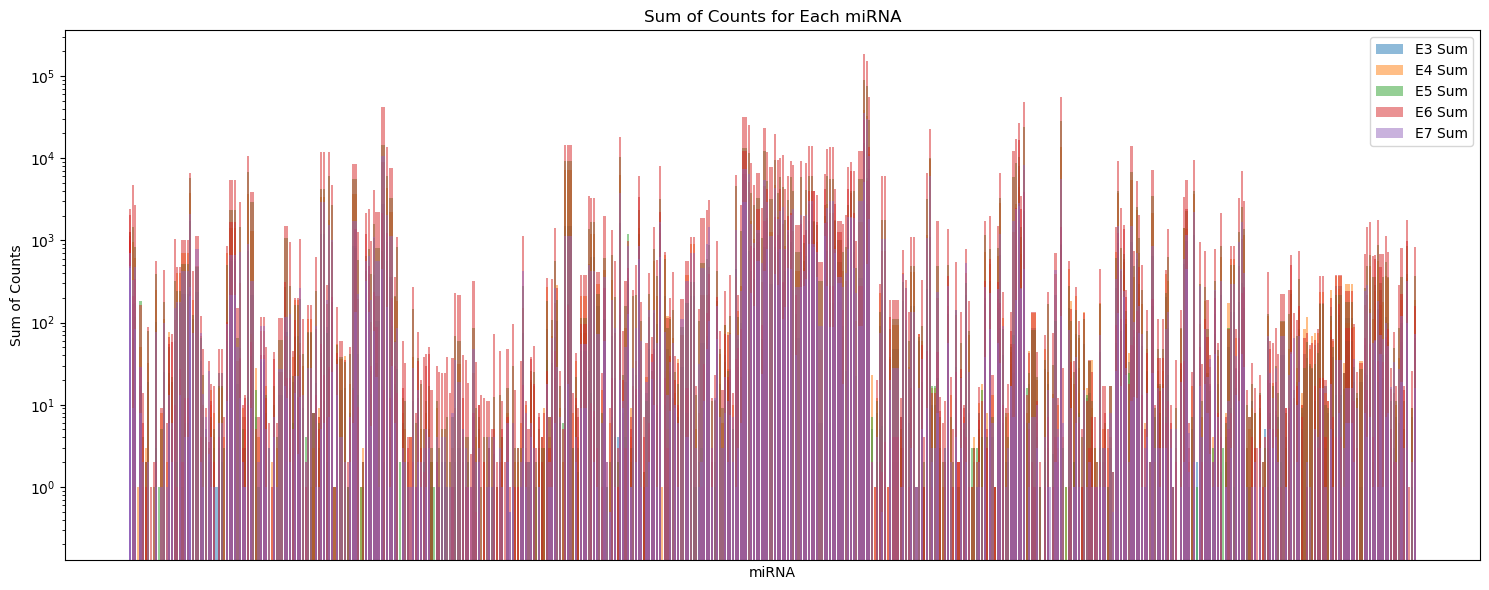

In [10]:
# plot the sum of counts for each stage and the total sum
plt.figure(figsize=(15, 6))
#plt.bar(df_sum_counts['miRNA'], df_sum_counts['sum_all'], label='Total Sum', alpha=0.5)
plt.bar(df_sum_counts['miRNA'], df_sum_counts['sum_E3'], label='E3 Sum', alpha=0.5)
plt.bar(df_sum_counts['miRNA'], df_sum_counts['sum_E4'], label='E4 Sum', alpha=0.5)
plt.bar(df_sum_counts['miRNA'], df_sum_counts['sum_E5'], label='E5 Sum', alpha=0.5)
plt.bar(df_sum_counts['miRNA'], df_sum_counts['sum_E6'], label='E6 Sum', alpha=0.5)
plt.bar(df_sum_counts['miRNA'], df_sum_counts['sum_E7'], label='E7 Sum', alpha=0.5)
plt.xlabel('miRNA')
plt.ylabel('Sum of Counts')
plt.title('Sum of Counts for Each miRNA')
plt.yscale('log')
plt.xticks([], [])
plt.legend()
plt.tight_layout()
plt.show()

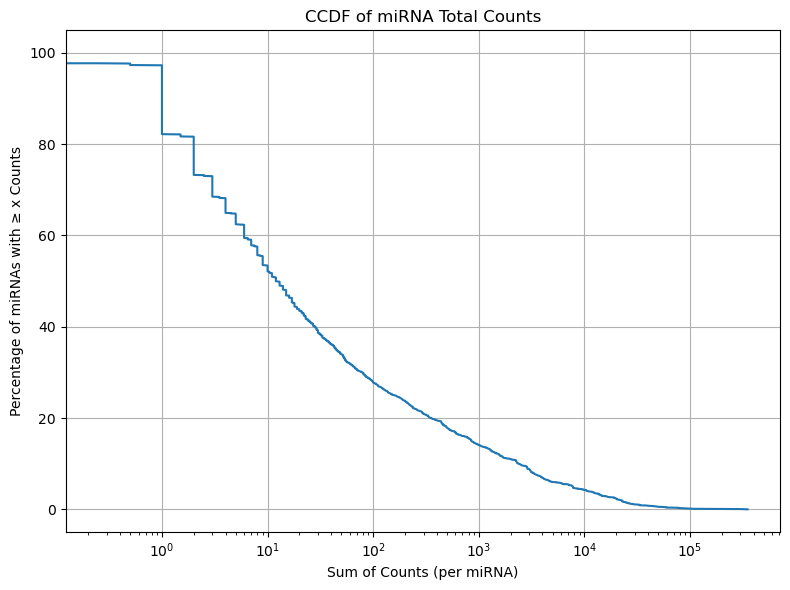

In [11]:
# Get the counts for all miRNAs
counts = df_sum_counts['sum_all'].values

# Sort counts in ascending order
sorted_counts = np.sort(counts)

# Compute the CCDF: percentage of miRNAs with count ≥ x
ccdf_y = 1.0 - np.arange(1, len(sorted_counts)+1) / len(sorted_counts)

plt.figure(figsize=(8, 6))
plt.plot(sorted_counts, ccdf_y * 100)
plt.xscale('log')
plt.xlabel('Sum of Counts (per miRNA)')
plt.ylabel('Percentage of miRNAs with ≥ x Counts')
plt.title('CCDF of miRNA Total Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

### Filter top expressed miRNAs

In [12]:
df_coseq = df_coseq_all[df_coseq_all.iloc[:, 0] != 'unknown_mirna']
df_coseq = df_coseq.drop(columns=['type'])
df_coseq = df_coseq.set_index(df_coseq.columns[0])

df_coseq_norm = normalize_df_per_column(df_coseq) if normalize_per_column else df_coseq

df_coseq_stages = [df_coseq_norm.loc[:, df_coseq_norm.columns.str.startswith((stage, 'ID', 'unknown_mirna', 'type'))] for stage in stages]

print("Number of cells in each stage:")
for i, stage in enumerate(stages):
	print(f"{stage}: {df_coseq_stages[i].shape[1]}")

stage_cell_num = [df_coseq_stages[i].shape[1] for i in range(len(stages))]

Number of cells in each stage:
E3: 20
E4: 115
E5: 339
E6: 489
E7: 187


___________________________________

### Parse the miRNA pairs

In [7]:
om_pairs_path = f'../Motif_analysis/PPI_Bifan/ohnomirna_pairs_predict_Hsa_existent.names.extended_info.flagged_WGD_host_genes.tsv'
pm_pairs_path = f'../3_retrieve_Hsa_paralogs/mgdb_3_hsa.premirna_paralog_pairs.extended_info.tsv'

om_pairs_df = pd.read_csv(om_pairs_path, sep='\t', header=0)
pm_pairs_df = pd.read_csv(pm_pairs_path, sep='\t', header=None)

print("Number of pairs BEFORE 2R filtering:", pm_pairs_df.shape[0])

pm_pairs_filtered_df = pm_pairs_df[~pm_pairs_df[0].apply(all_clades_in_pre2R) | ~pm_pairs_df[1].apply(all_clades_in_pre2R)]
pm_pairs_removed_df = pm_pairs_df[pm_pairs_df[0].apply(all_clades_in_pre2R) & pm_pairs_df[1].apply(all_clades_in_pre2R)]

print("Number of pairs AFTER 2R filtering:", pm_pairs_filtered_df.shape[0], "\nRemoved:", pm_pairs_removed_df.shape[0])

Number of pairs BEFORE 2R filtering: 2655
Number of pairs AFTER 2R filtering: 879 
Removed: 1776


In [8]:
om_pairs_intragenic_df = om_pairs_df[~om_pairs_df['host_gene_name_1'].isin(['intergenic']) & ~om_pairs_df['host_gene_name_2'].isin(['intergenic'])]
om_pairs_intergenic_df = om_pairs_df[om_pairs_df['host_gene_name_1'].isin(['intergenic']) | om_pairs_df['host_gene_name_2'].isin(['intergenic'])]

In [9]:
om_pairs = om_pairs_df.iloc[:, [0, 7]].values
om_pairs = [tuple(sorted(pair)) for pair in om_pairs]
om_pairs = list(set(om_pairs))
print(f"Number of om pairs: {len(om_pairs)}", file=sys.stderr)

om_pairs_intragenic = om_pairs_intragenic_df.iloc[:, [0, 7]].values
om_pairs_intragenic = [tuple(sorted(pair)) for pair in om_pairs_intragenic]
om_pairs_intragenic = list(set(om_pairs_intragenic))
print(f"Number of om pairs intragenic: {len(om_pairs_intragenic)}", file=sys.stderr)

om_pairs_intergenic = om_pairs_intergenic_df.iloc[:, [0, 7]].values
om_pairs_intergenic = [tuple(sorted(pair)) for pair in om_pairs_intergenic]
om_pairs_intergenic = list(set(om_pairs_intergenic))
print(f"Number of om pairs intergenic: {len(om_pairs_intergenic)}", file=sys.stderr)

pm_pairs = pm_pairs_df.iloc[:, [0, 5]].values
pm_pairs = [tuple(sorted(pair)) for pair in pm_pairs]
pm_pairs = list(set(pm_pairs))
print(f"Number of pm pairs: {len(pm_pairs)}", file=sys.stderr)

pm_pairs_filtered = pm_pairs_filtered_df.iloc[:, [0, 5]].values
pm_pairs_filtered = [tuple(sorted(pair)) for pair in pm_pairs_filtered]
pm_pairs_filtered = list(set(pm_pairs_filtered))
print(f"Number of filtered pm pairs: {len(pm_pairs_filtered)}", file=sys.stderr)

# remove from pm_pairs those that are in om_pairs regardless of the order
pm_pairs_filtered = [pair for pair in pm_pairs_filtered if pair not in om_pairs]
print(f"Number of filtered pm pairs after filtering out om pairs: {len(pm_pairs_filtered)}", file=sys.stderr)

pm_pairs_removed = pm_pairs_removed_df.iloc[:, [0, 5]].values
pm_pairs_removed = [tuple(sorted(pair)) for pair in pm_pairs_removed]
pm_pairs_removed = list(set(pm_pairs_removed))
print(f"Number of removed pm pairs: {len(pm_pairs_removed)}", file=sys.stderr)

pm_pairs_removed = [pair for pair in pm_pairs_removed if pair not in om_pairs]
print(f"Number of removed pm pairs removed after filtering out om pairs: {len(pm_pairs_removed)}", file=sys.stderr)

if rm_430:
	pm_pairs_filtered = [pair for pair in pm_pairs_filtered if not any("Mir-430" in name for name in pair)]
	print(f"Number of filtered pm pairs filtered after filtering out Mir-430: {len(pm_pairs_filtered)}", file=sys.stderr)
	pm_pairs_removed = [pair for pair in pm_pairs_removed if not any("Mir-430" in name for name in pair)]
	print(f"Number of removed pm pairs removed after filtering out Mir-430: {len(pm_pairs_removed)}", file=sys.stderr)

Number of om pairs: 114
Number of om pairs intragenic: 25
Number of om pairs intergenic: 89
Number of pm pairs: 2467
Number of filtered pm pairs: 798
Number of filtered pm pairs after filtering out om pairs: 783
Number of removed pm pairs: 1669
Number of removed pm pairs removed after filtering out om pairs: 1570


____________________________________

## Compute distances

In [16]:
# "True" if you want to see the output of the distances (only when all the pairs are considered, so one file for SSD and one for WGD)
v = 1 

In [36]:
def compute_global_expression(mirna, expr_df, stage):
    """
    Return the total (global) expression of a miRNA across all samples.

    Parameters:
    - mirna (str): The name of the miRNA.
    - expr_df (pd.DataFrame): A DataFrame where rows are miRNAs and columns are samples.
    - stage (str): A label for the developmental stage (unused, but kept for consistency).

    Returns:
    - float: Sum of expression values for the given miRNA.
    """
    try:
        expression_values = expr_df.loc[mirna]
        if isinstance(expression_values, pd.DataFrame):  # Handle duplicates
            total_expression = expression_values.sum().sum()
        else:
            total_expression = expression_values.sum()
        return total_expression
    except KeyError:
        print(f"miRNA '{mirna}' not found in the expression DataFrame.")
        return None

In [ ]:
def compute_pair_distance(mirna_1, mirna_2, expr_df, metric, report_label, stage, normalize_vectors=True, verbose=False, rm_all_zero=False, duplicate_handling='max', drop_same=False):
	"""
	Compute the distance between two miRNAs based on their expression levels across tissues.
	If duplicate entries are found for a miRNA, the maximum expression vector is used.
	"""
	if drop_same:
		file = f'./reports/{report_label}_{metric}_{duplicate_handling}dup_dropsame_report.txt'
	else:
		file = f'./reports/{report_label}_{metric}_{duplicate_handling}dup_report.txt'

	if normalize_vectors:
		# Normalize the expression vectors per column (cell)
		expr_df = expr_df.div(expr_df.sum(axis=0), axis=1)


	try:
		vecs_1 = expr_df.loc[mirna_1]
		vecs_2 = expr_df.loc[mirna_2]

		# If a single row is returned, convert to DataFrame for consistency
		if isinstance(vecs_1, pd.Series):
			vecs_1 = vecs_1.to_frame().T
		if isinstance(vecs_2, pd.Series):
			vecs_2 = vecs_2.to_frame().T

		if duplicate_handling == 'max':
			vector_1 = vecs_1.max(axis=0).values
			vector_2 = vecs_2.max(axis=0).values
		if duplicate_handling == 'mean':
			vector_1 = vecs_1.mean(axis=0).values
			vector_2 = vecs_2.mean(axis=0).values
		if verbose:
			# print the two vectors on a file called 'report.txt'
			with open(file, 'a') as f:
				f.write(f"> STAGE {stage}: {mirna_1} - {mirna_2}\n")
				f.write("Vector 1: [" + ", ".join(f"{x:.5f}" for x in vector_1) + "]\n")
				f.write("Vector 2: [" + ", ".join(f"{x:.5f}" for x in vector_2) + "]\n")

		if drop_same:
			if np.array_equal(vector_1, vector_2):
				with open(file, 'a') as f:
					f.write(f"Distance between {mirna_1} and {mirna_2} not computed\n")
					f.write("\n")
				return None

		if rm_all_zero:
			if np.all(vector_1 == 0) or np.all(vector_2 == 0):
				print(f"One of the miRNAs '{mirna_1}' or '{mirna_2}' has all zero expression values, the pair is discarded.", file=sys.stderr)
				with open(file, 'a') as f:
					f.write(f"Distance between {mirna_1} and {mirna_2} not computed\n")
					f.write("\n")
				return None

	except KeyError:
		print(f"One of the miRNAs '{mirna_1}' or '{mirna_2}' does not exist in the expression DataFrame, impossible to compare expressions.", file=sys.stderr)
		with open(file, 'a') as f:
					f.write(f"Distance between {mirna_1} and {mirna_2} not computed\n")
					f.write("\n")
		return None

	if metric == 'euclidean':
		distance = np.linalg.norm(vector_1 - vector_2)
	elif metric == 'normalized_euclidean':
		distance = np.linalg.norm(vector_1 - vector_2) / np.sqrt(len(vector_1))
	elif metric == 'normalized_geometric':
		distance = np.linalg.norm(vector_1 - vector_2) / np.sqrt(np.sum(vector_1**2) + np.sum(vector_2**2))
	elif metric == 'cosine':
		distance = np.dot(vector_1, vector_2) / (np.linalg.norm(vector_1) * np.linalg.norm(vector_2))
	elif metric in ['correlation', 'pearson']:
		distance = np.corrcoef(vector_1, vector_2)[0, 1]
	elif metric == 'normalized_manhattan':
		distance = np.sum(np.abs(vector_1 - vector_2)) / len(vector_1)
	elif metric == 'spearman':
		distance, _ = spearmanr(vector_1, vector_2)
	elif metric == 'normalized_mutual_information':
		distance = normalized_mutual_info_score(vector_1, vector_2)
	elif metric == 'kullback_leibler':
		distance = kl_div
	else:
		raise ValueError("Unsupported metric. Choose from 'euclidean', 'cosine', 'correlation', or 'manhattan'.")
	
	if verbose:
		with open(file, 'a') as f:
			f.write(f"Distance between {mirna_1} and {mirna_2} using {metric}: {distance}\n")
			f.write("\n")

	return distance
pair_dist = compute_pair_distance

In [18]:
metric = 'spearman'
df_to_be_used = normalize_df_per_column(df_coseq_all_new)

### Distances between all OhnomiRNAs pairs + absolute expression

In [92]:
def unique_elements_from_tuples(tuple_list):
    """
    Given a list of tuples, return a list of unique elements across all tuples.

    Parameters:
    - tuple_list: List of tuples (e.g., [(a, b), (b, c), ...])

    Returns:
    - List of unique elements.
    """
    unique = set()
    for t in tuple_list:
        unique.update(t)
    return list(unique)

In [108]:
om = set(unique_elements_from_tuples(om_pairs))

In [100]:
single_om_expr_stages = []

for stage in stages:
	
	acm = set()

	df_stage = df_coseq_all_new.loc[:, df_coseq_all_new.columns.str.startswith(stage)]
	stage_expr_vec = []

	for mirna in unique_elements_from_tuples(om_pairs):
		
		if mirna in acm:
			continue
		
		acm.add(mirna)

		if mirna not in df_stage.index:
			print(f"miRNA '{mirna}' not found in the expression DataFrame for stage {stage}.")
			continue
		else:
			# Compute the global expression
			global_expression = compute_global_expression(mirna, df_stage, stage)
			
		stage_expr_vec.append(global_expression)

	single_om_expr_stages.append(stage_expr_vec)


In [118]:
single_pm_expr_stages = []

for stage in stages:

	acm = set()

	df_stage = df_coseq_all_new.loc[:, df_coseq_all_new.columns.str.startswith(stage)]
	stage_expr_vec = []

	for mirna in unique_elements_from_tuples(pm_pairs):

		if mirna in acm:
			continue
		if mirna in om:
			print(f"miRNA '{mirna}' is in om pairs, skipping.")
			continue

		# if the name of the miRNA starts with "Hsa-Mir-430", skip it
		if True and mirna.startswith("Hsa-Mir-430"):
			print(f"miRNA '{mirna}' starts with 'Hsa-Mir-430', skipping.")
			continue
		
		acm.add(mirna)

		if mirna not in df_stage.index:
			print(f"miRNA '{mirna}' not found in the expression DataFrame for stage {stage}.")
			continue
		else:
			# Compute the global expression
			global_expression = compute_global_expression(mirna, df_stage, stage)
			print(f"miRNA '{mirna}' found in the expression DataFrame for stage {stage}. Global expression = {str(global_expression)}.")
			
		stage_expr_vec.append(global_expression)

	single_pm_expr_stages.append(stage_expr_vec)

miRNA 'Hsa-Mir-506-P1d' not found in the expression DataFrame for stage E3.
miRNA 'Hsa-Mir-430-P5' starts with 'Hsa-Mir-430', skipping.
miRNA 'Hsa-Mir-506-P1c1' found in the expression DataFrame for stage E3. Global expression = 281.0.
miRNA 'Hsa-Mir-337-as' not found in the expression DataFrame for stage E3.
miRNA 'Hsa-Mir-129-P1' is in om pairs, skipping.
miRNA 'Hsa-Mir-430-P31b' starts with 'Hsa-Mir-430', skipping.
miRNA 'Hsa-Mir-132-P2' found in the expression DataFrame for stage E3. Global expression = 4.0.
miRNA 'Hsa-Let-7-P2b3' is in om pairs, skipping.
miRNA 'Hsa-Mir-320-P2b' found in the expression DataFrame for stage E3. Global expression = 235.99599999999998.
miRNA 'Hsa-Mir-10-P1c' is in om pairs, skipping.
miRNA 'Hsa-Mir-199-P2' is in om pairs, skipping.
miRNA 'Hsa-Mir-430-P40b' starts with 'Hsa-Mir-430', skipping.
miRNA 'Hsa-Mir-17-P2c' is in om pairs, skipping.
miRNA 'Hsa-Let-7-P2b1' is in om pairs, skipping.
miRNA 'Hsa-Mir-430-P33a' starts with 'Hsa-Mir-430', skipping.
m

______________________________

In [120]:
def plot_expression_boxplot_comparison(expressions, label, scn=None, stages=None, ylim=[0., 10000]):
    """
    Plots boxplots for miRNA global expression values across stages.

    Parameters:
    - expressions: List of lists of float values. Each sublist contains global expression
                   values for unique miRNAs in one stage.
    - label: String label for the y-axis (e.g., 'OM').
    - scn: List of sample sizes per stage (optional, for x-axis annotation).
    - stages: List of stage names (optional). Defaults to "Stage 1", "Stage 2", ...
    """
    cleaned_expressions = [list(np.array(stage_expr)[~np.isnan(stage_expr)]) for stage_expr in expressions]
    num_stages = len(cleaned_expressions)
    positions = list(range(1, num_stages + 1))

    if stages is None:
        stages = [f"Stage {i+1}" for i in range(num_stages)]

    fig, ax = plt.subplots(figsize=(13, 6))

    # Boxplot
    ax.boxplot(cleaned_expressions, positions=positions, widths=0.6, patch_artist=True,
               boxprops=dict(facecolor='lightgreen', color='green'),
               medianprops=dict(color='darkgreen'),
               whiskerprops=dict(color='green'),
               capprops=dict(color='green'),
               showfliers=False)

    ax.set_xticks(positions)

    n_mirnas = [len(stage_expr) for stage_expr in cleaned_expressions]
    
    if scn is not None:
        labels_scn = [f"{stage}\n(n cells={scn[i]}, n miRNAs={n_mirnas[i]})" for i, stage in enumerate(stages)]
    else:
        labels_scn = [f"{stage}\n(n miRNAs={n_mirnas[i]})" for i, stage in enumerate(stages)]

    ax.set_xticklabels(labels_scn, rotation=45)
    ax.set_ylabel(f"{label} Global Expression")
    ax.set_title(f"{label} Global Expression Across Stages")
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(ylim)

    mean_median = np.mean([np.median(vals) for vals in cleaned_expressions if len(vals) > 0])
    ax.axhline(mean_median, color='blue', linestyle='--', linewidth=2, alpha=0.5, label=f"Mean median: {mean_median:.2f}")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_distance_boxplot_comparison(distances, label, metric, scn=None, stages=None):
    """
    Plots boxplots and scatter plots for distance distributions across stages.

    Parameters:
    - distances: List of lists, each sublist contains distances for one stage.
    - label: String label for the y-axis title (e.g., 'OM').
    - metric: Name of the metric (used in plot title).
    - scn: List of sample sizes per stage (used in x-axis labels).
    - stages: Optional list of stage names; defaults to numeric indices if None.
    """
    # Filter NaNs from each sublist
    cleaned_distances = [list(np.array(d)[~np.isnan(d)]) for d in distances]
    num_stages = len(cleaned_distances)
    positions = list(range(1, num_stages + 1))

    if stages is None:
        stages = [f"Stage {i+1}" for i in range(num_stages)]

    fig, ax = plt.subplots(figsize=(13, 6))

    # Scatter individual distances (jittered on the x-axis)
    for i, stage_distances in enumerate(cleaned_distances):
        x_vals = [positions[i]] * len(stage_distances)
        #ax.scatter(x_vals, stage_distances, alpha=0.5, color='gray', s=10)

    # Boxplot
    ax.boxplot(cleaned_distances, positions=positions, widths=0.6, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='blue'),
               medianprops=dict(color='red'),
               whiskerprops=dict(color='blue'),
               capprops=dict(color='blue'),
               showfliers=False)

    ax.set_xticks(positions)
    
    n_considered_pairs = [len(d) for d in cleaned_distances]
    
    if scn is not None:
        labels_scn = [f"{stage}\n(n cells={scn[i]}, n pairs={n_considered_pairs[i]})" for i, stage in enumerate(stages)]
    else:
        labels_scn = stages
	
    ax.set_ylim(-1.2, 1.2)
        
	# put an horizontal line at y=0
    #ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    #ax.axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    #ax.axhline(-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

    mean_median = np.mean([np.median(d) for d in cleaned_distances])
    ax.axhline(mean_median, color='darkgreen', linestyle='--', linewidth=2, alpha=0.5, label=f"{mean_median:.2f}")
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    ax.set_xticklabels(labels_scn, rotation=45)
    ax.set_ylabel(f"{label} Pair Distance ({metric})")
    ax.set_title(f"{label} Pair Distances Across Stages ({metric}) - n. pairs: {len(cleaned_distances[0])}")
    plt.legend()
    plt.show()

______________________________________________

## Expression

#### Om miRNAs

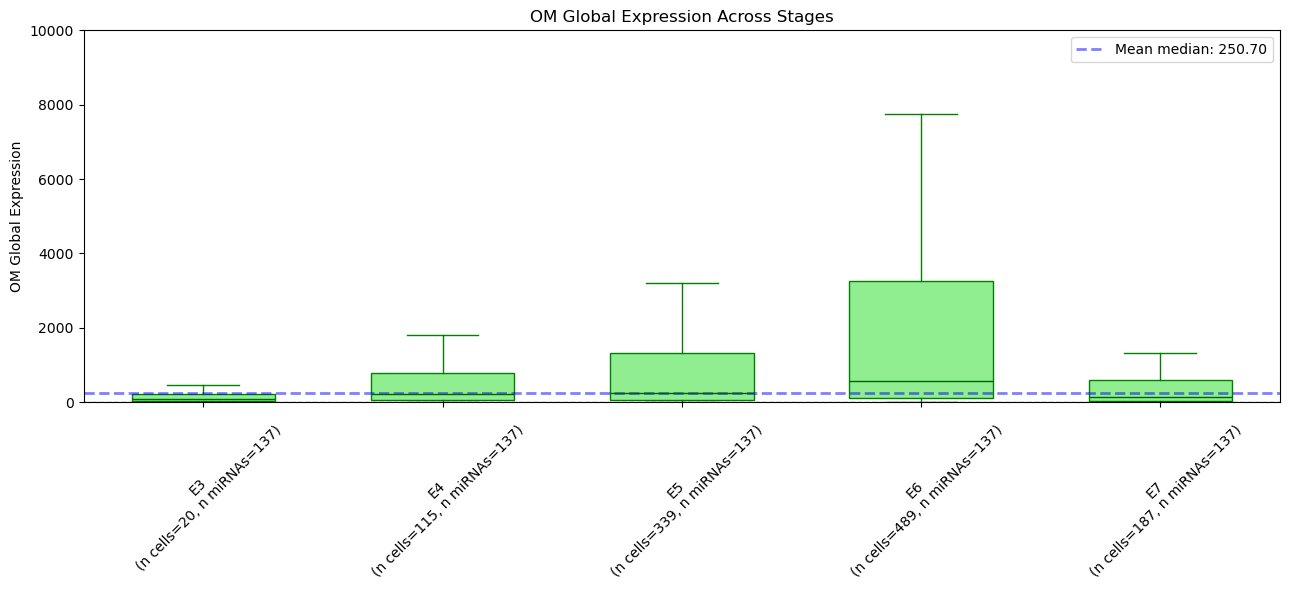

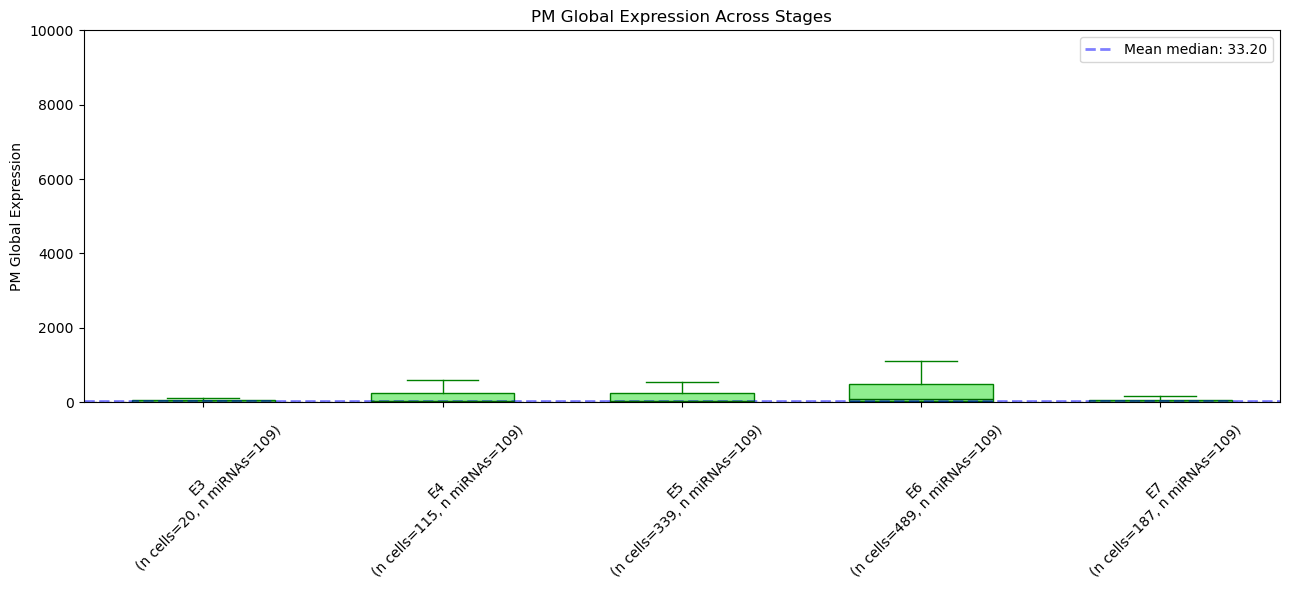

In [121]:
plot_expression_boxplot_comparison(single_om_expr_stages, 'OM', scn=stage_cell_num, stages=stages)
plot_expression_boxplot_comparison(single_pm_expr_stages, 'PM', scn=stage_cell_num, stages=stages)

___________________________________

## Distance

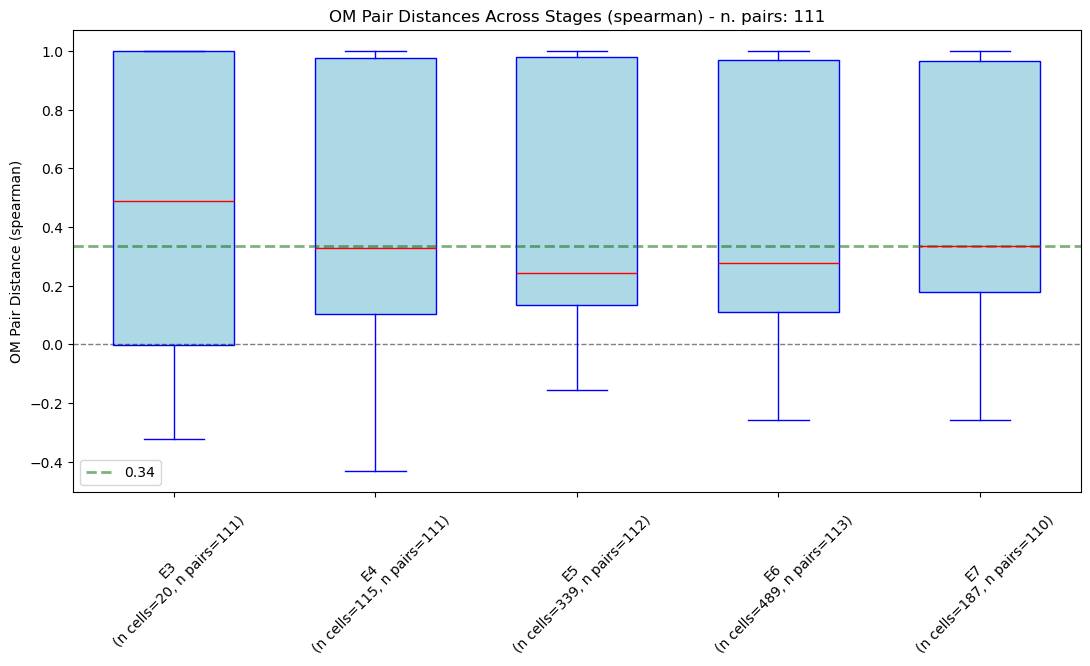

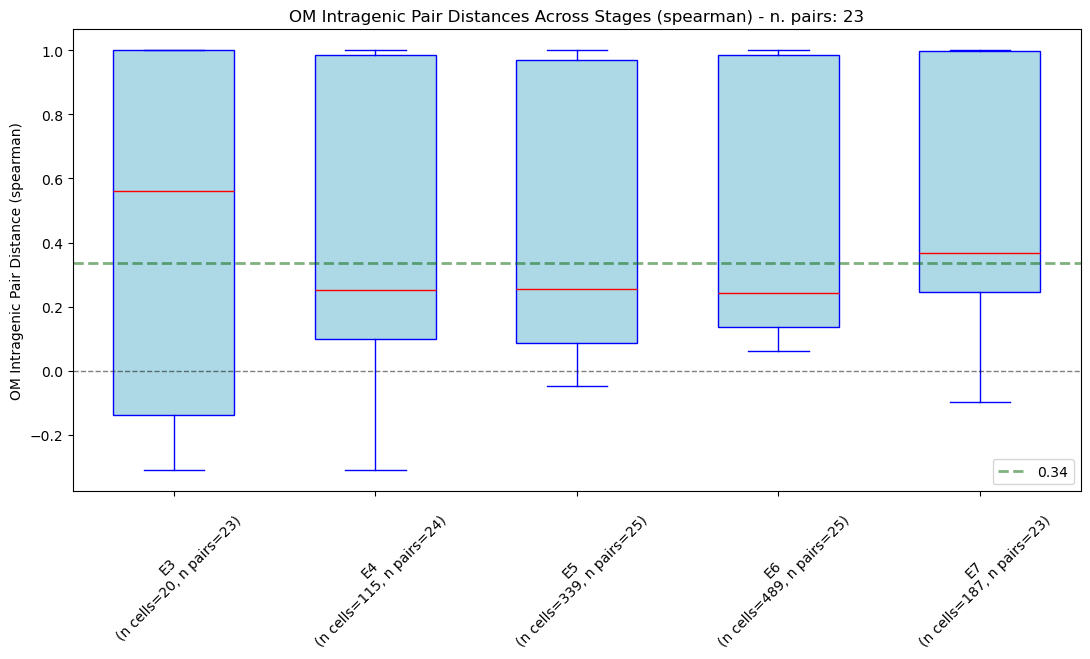

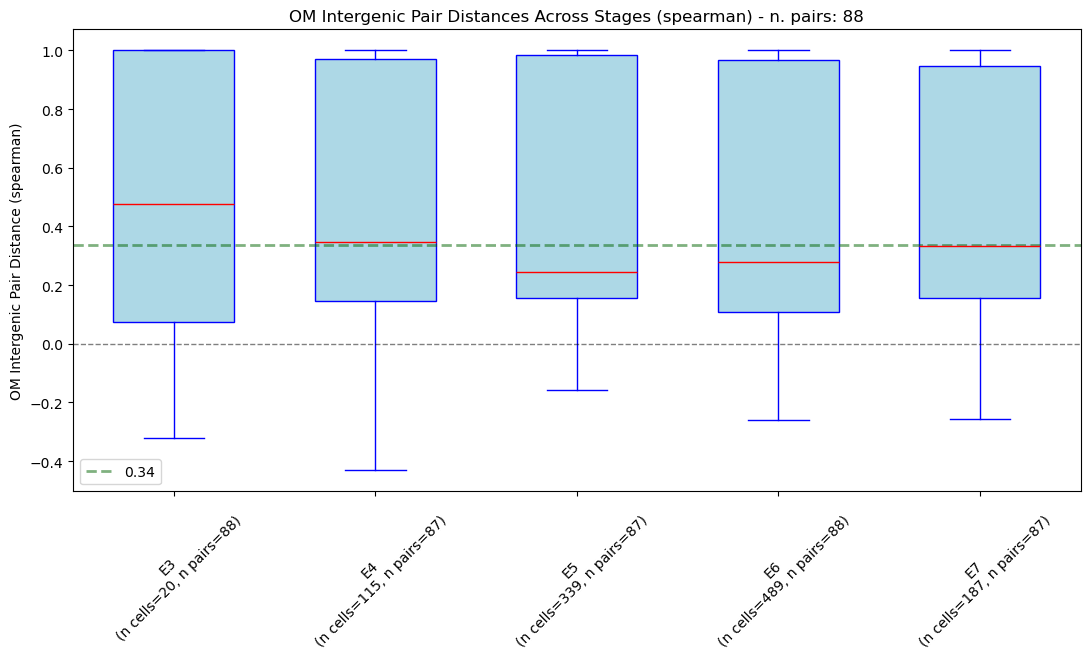

In [60]:
plot_distance_boxplot_comparison(om_distances_stages, "OM", metric, stage_cell_num, stages)
plot_distance_boxplot_comparison(om_intragenic_distances_stages, "OM Intragenic", metric, stage_cell_num, stages)
plot_distance_boxplot_comparison(om_intergenic_distances_stages, "OM Intergenic", metric, stage_cell_num, stages)

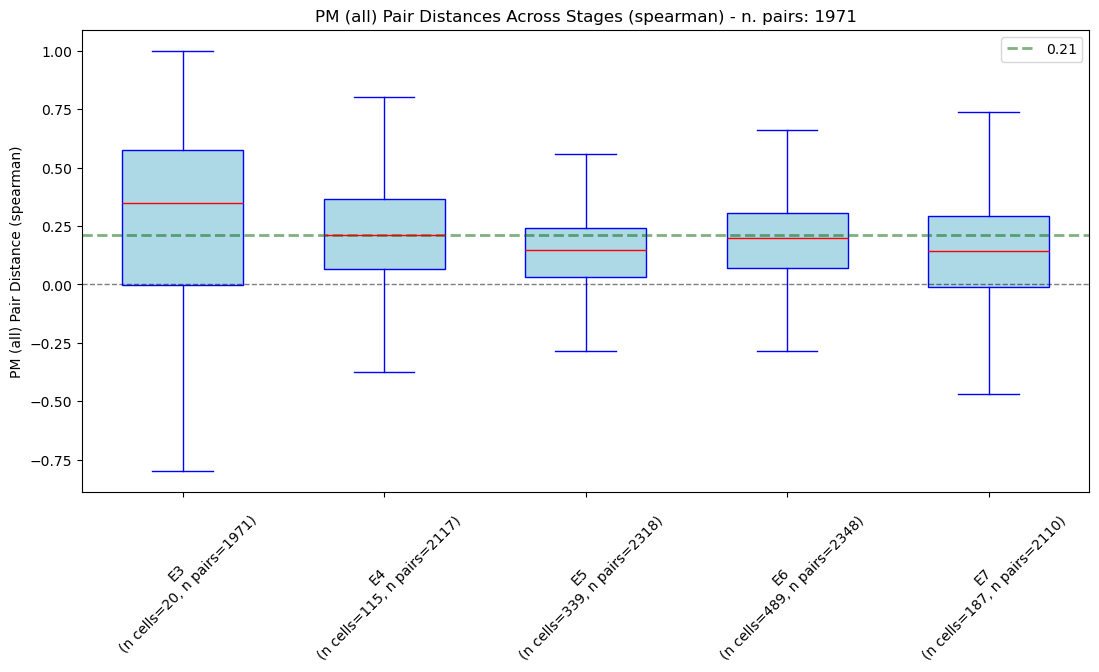

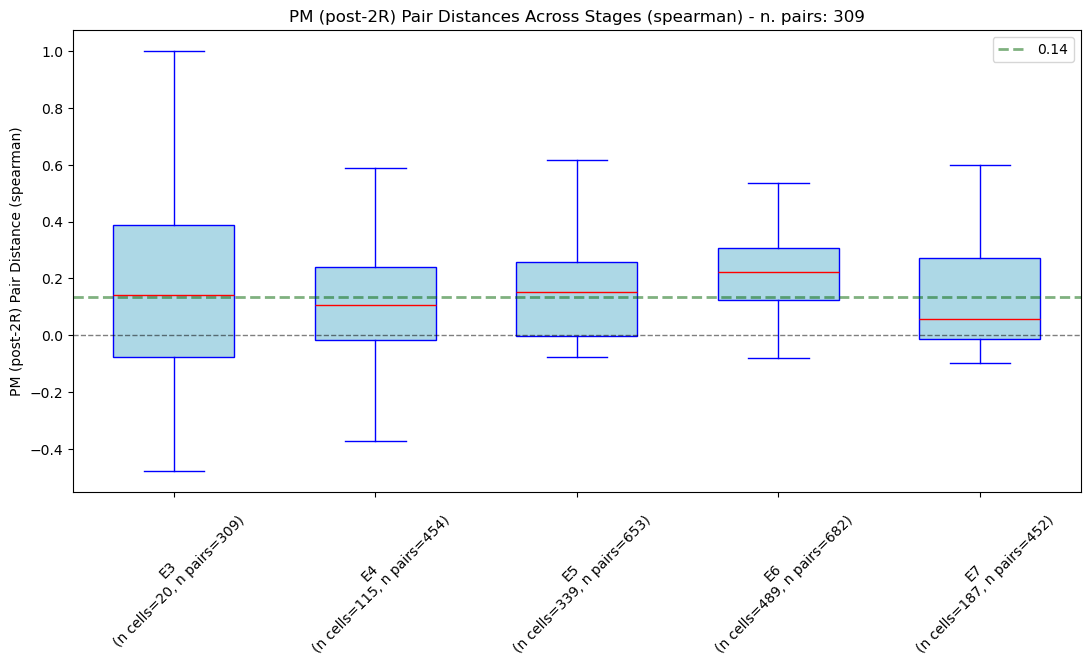

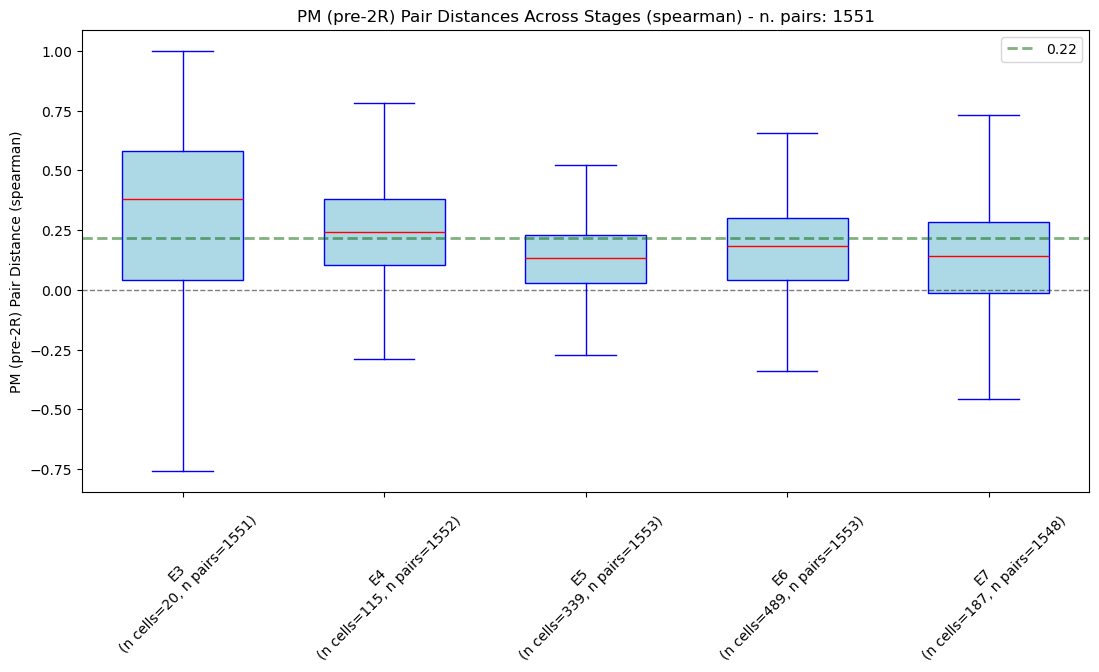

In [61]:
plot_distance_boxplot_comparison(pm_all_distances_stages, "PM (all)", metric, stage_cell_num, stages)
plot_distance_boxplot_comparison(pm_filtered_distances_stages, "PM (post-2R)", metric, stage_cell_num, stages)
plot_distance_boxplot_comparison(pm_removed_distances_stages, "PM (pre-2R)", metric, stage_cell_num, stages)

____________________